Sentimental Analysis can be very useful to find out depression and cure it before someone gets into serious trouble.

Detecting depression in Tweets

Importing relevant libraries

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import contractions
import unicodedata
import emoji
import torch
import numpy as np
import os
import torch
import nltk
import spacy
import contractions
import unicodedata
from plotly import figure_factory
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB
from spellchecker import SpellChecker
from emot.emo_unicode import UNICODE_EMOJI
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from transformers import RobertaConfig, RobertaForSequenceClassification, RobertaTokenizerFast, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Bidirectional, GRU, MaxPooling1D, Flatten, Dropout, Conv1D
from sklearn.model_selection import train_test_split



# Download the stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felixdelaliadigbli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felixdelaliadigbli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load Data

In [2]:
#training dataset
#train = pd.read_csv("data/train.csv")

#test dataset
#test = pd.read_csv("data/test.csv")

df = pd.read_csv("data/sentiment_tweets.csv")



In [3]:
print(df.shape)


(10314, 3)


So We have 10314 tweets in the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message to examine         10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [5]:
missing_values = df.isnull().any()
print(missing_values)

Index                        False
message to examine           False
label (depression result)    False
dtype: bool


NO null values in the dataset.

# Exploratory Data Analysis

Distribution of tweets in the train set


In [6]:
df.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


Renamaing the Columns Names

In [7]:
df.rename(columns={'message to examine': 'tweet',
          'label (depression result)': 'sentiment'}, inplace=True)
df.head()

,Index,tweet,sentiment
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [8]:
temp = df.groupby('sentiment').count()[
    'tweet'].reset_index().sort_values(by='tweet', ascending=False)
temp.head()

,sentiment,tweet
0,0,8000
1,1,2314


<Axes: xlabel='sentiment', ylabel='count'>

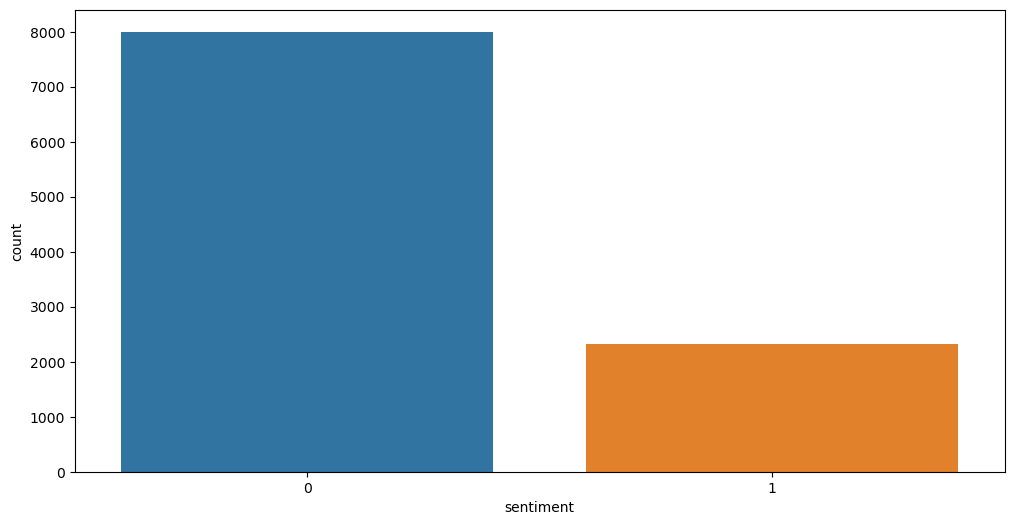

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', data=df)

number of words per each tweet

In [10]:
#number of words per tweet
df['Num_words'] = df['tweet'].apply(lambda x: len(str(x).split()))
df.head()

,Index,tweet,sentiment,Num_words
0,106,just had a real good moment. i missssssssss hi...,0,11
1,217,is reading manga http://plurk.com/p/mzp1e,0,4
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,4
3,288,@lapcat Need to send 'em to my accountant tomo...,0,22
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,5


Distribution of number of words

/Users/felixdelaliadigbli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


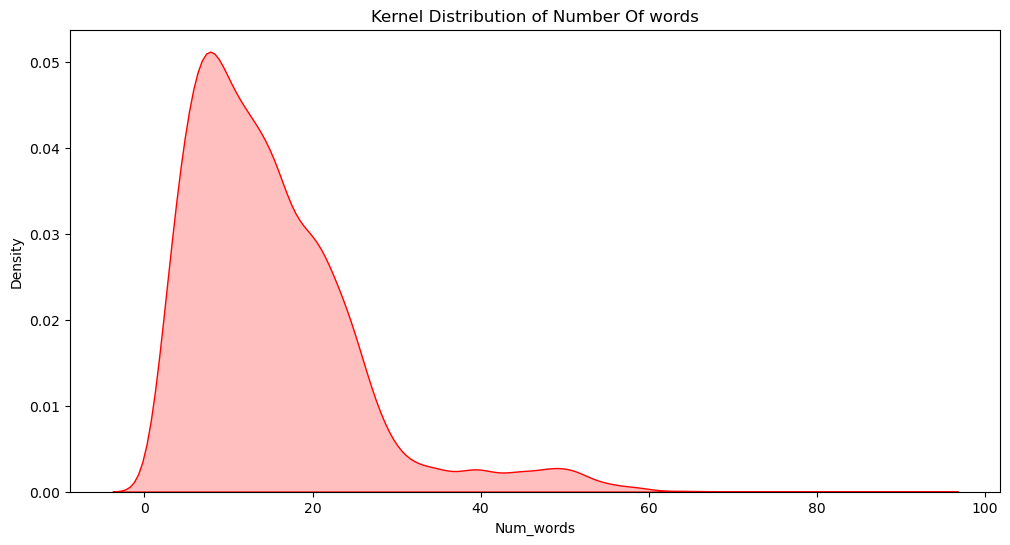

In [11]:
plt.figure(figsize=(12, 6))
p1 = sns.kdeplot(df['Num_words'], fill=True, color="r").set_title('Kernel Distribution of Number Of words')

The KDE plot indicates that the dataset, primarily contains short tweets with most entries having between 10 to 15 words. There is a right skew, suggesting a presence of some longer texts. These characteristics imply that while the dataset is suitable for analyzing brief expressions of sentiment, the variability in text lengths could pose challenges for sentiment analysis models, especially when dealing with the nuanced sentiments of longer texts. Outliers with significantly higher word counts may require special consideration during preprocessing to ensure the sentiment analysis is accurate across the dataset

Word Cloud

Removing stop words before word cloud

In [12]:
# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(df)

# set stopwords to english
stop_words = set(stopwords.words('english'))



# Function to clean and lemmatize a single tweet
def clean_tweet(tweet):
    # Remove HTML tags using BeautifulSoup
    tweet = BeautifulSoup(tweet, 'lxml').get_text()

    # Remove URLs
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)

    # Remove @mentions and #hashtags
    tweet = re.sub(r'@\S+|#\S+', '', tweet)

    # Remove RT (retweet) symbol
    tweet = re.sub(r'\bRT\b', '', tweet)

    # Remove non-alphanumeric characters (punctuation, emojis, etc.)
    tweet = re.sub(r'\W+', ' ', tweet)

    # Remove digits
    tweet = re.sub(r'\d+', '', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    # Tokenize the tweet
    words = word_tokenize(tweet)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Rejoin words
    join_words = ' '.join(words)
    return join_words


df['cleaned_doc'] = df['tweet'].apply(clean_tweet)

/var/folders/yz/2pbqqbpn6sj4b27rbp_l9n280000gn/T/ipykernel_61409/2076361521.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


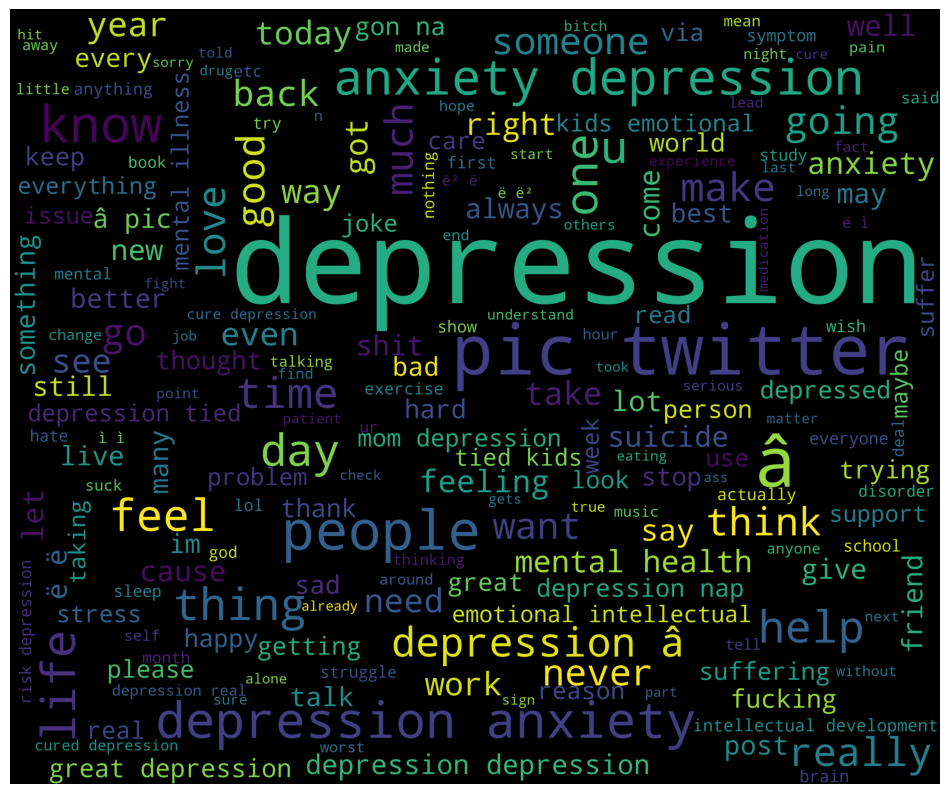

In [13]:
# Wordcloud for Depressive words
new_df = df[df['sentiment'] == 1]
words = ' '.join(new_df['cleaned_doc'])
cleaned_word = " ".join([word for word in words.split()
                         if 'http' not in word
                         and not word.startswith('@')
                         and word != 'RT'
                         ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(cleaned_word)
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

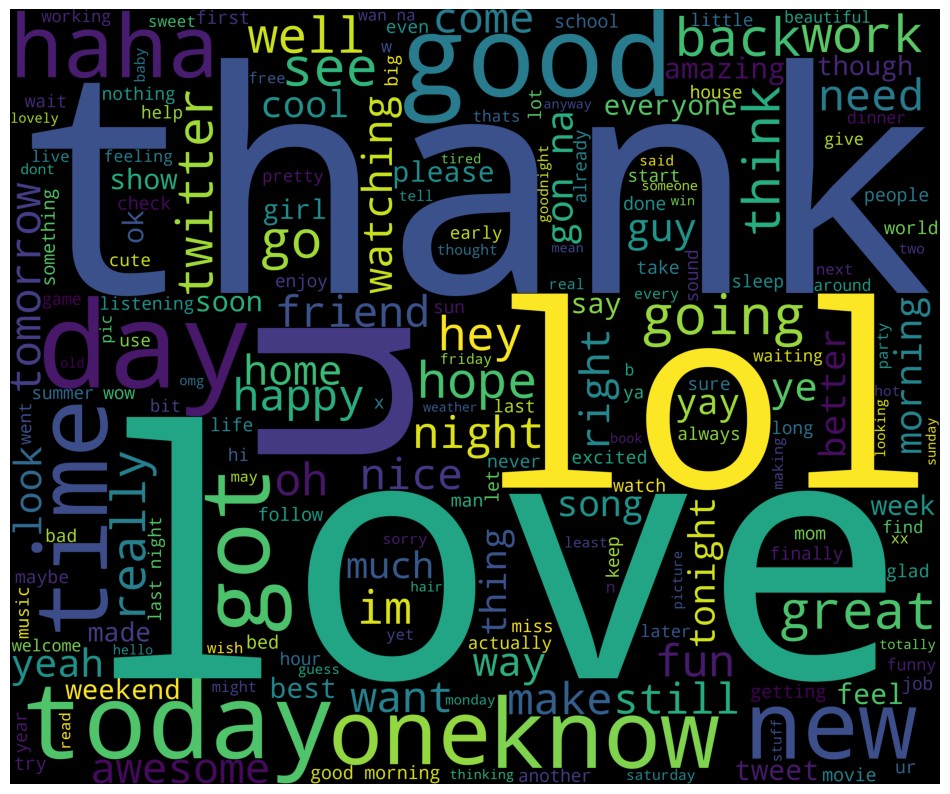

In [14]:
# Wordcloud for Non depresive words
new_df = df[df['sentiment'] == 0]
words = ' '.join(new_df['cleaned_doc'])
cleaned_word = " ".join([word for word in words.split()
                         if 'http' not in word
                         and not word.startswith('@')
                         and word != 'RT'
                         ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(cleaned_word)
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Cleaning the dataset and Preprocessing

Function to clean the tweets and handle negation

In [15]:
# Function to handle negation in a tweet
def handle_negation(tweet):
    doc = lemmatizer(tweet)
    processed_words = []
    negate = False
    for token in doc:
        if token.dep_ == "neg":
            negate = True
        elif token.pos_ == "PUNCT":
            negate = False
        if negate and token.dep_ != "neg":
            processed_words.append("not_" + token.text)
        else:
            processed_words.append(token.text)
    return " ".join(processed_words)

In [16]:
# Function to remove emojis from text
def convert_emojis_to_text(text):
    return emoji.demojize(text)


Handling ChatWords

In [17]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "UR": "Your",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [18]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

In [19]:
# Set stopwords to English
stop_words = set(stopwords.words('english'))
# instantiating spell checker
spell = SpellChecker()
# Function to clean, lemmatize, and handle negation in a single tweet

# Load the SpaCy language model
lemmatizer = spacy.load('en_core_web_sm')


def clean_tweet(tweet):
    # Expand contractions
    tweet = contractions.fix(tweet)

    # Remove HTML tags using BeautifulSoup
    tweet = BeautifulSoup(tweet, 'lxml').get_text()

    # Remove URLs
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)

    # Remove @mentions and #hashtags
    tweet = re.sub(r'@\S+|#\S+', '', tweet)

    # Remove RT (retweet) symbol
    tweet = re.sub(r'\bRT\b', '', tweet)

    # Remove non-alphanumeric characters and puntuations
    tweet = re.sub(r'\W+', ' ', tweet)

    # Remove digits
    tweet = re.sub(r'\d+', '', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    # Remove accented characters
    tweet = unicodedata.normalize('NFKD', tweet).encode(
        'ascii', 'ignore').decode('utf-8', 'ignore')

    # Convert emojis to tweet
    tweet = convert_emojis_to_text(tweet)

    #applying chat words function to twwets
    tweet = replace_chat_words(tweet)

    # Tokenize the tweet
    words = word_tokenize(tweet)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Correct spelling and filter out None values
    words = [spell.correction(word) for word in words if spell.correction(word) is not None]


    # Rejoin words
    join_words = ' '.join(words)

    # Handle negation
    join_words = handle_negation(join_words)

    # Lemmatization with SpaCy
    doc = lemmatizer(join_words)
    lemmatized_words = [token.lemma_ for token in doc if not token.is_punct]

    # Rejoin words and remove excessive whitespace
    cleaned_tweet = ' '.join(lemmatized_words).strip()

    return cleaned_tweet

In [20]:

# Convert the train dataset to a pandas DataFrame
df = pd.DataFrame(df)

Apply the clean_tweet function to each dataframes in the DataFrame

In [21]:
df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)

/var/folders/yz/2pbqqbpn6sj4b27rbp_l9n280000gn/T/ipykernel_61409/1308597761.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


In [22]:
# droping missing values if any
df = df.dropna()

In [23]:
df_cleaned_tweet = df

In [24]:
df_cleaned_tweet.head()

,Index,tweet,sentiment,Num_words,cleaned_doc,cleaned_tweet
0,106,just had a real good moment. i missssssssss hi...,0,11,real good moment missssssssss much,real good moment much
1,217,is reading manga http://plurk.com/p/mzp1e,0,4,reading manga,read mango
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,4,,
3,288,@lapcat Need to send 'em to my accountant tomo...,0,22,need send em accountant tomorrow oddly even re...,need send accountant tomorrow oddly even refer...
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,5,add myspace myspace com lookthunder,add space space come


In [25]:
df.to_csv('data/cleaned_tweet.csv', index=False)

In [26]:
df.head()

,Index,tweet,sentiment,Num_words,cleaned_doc,cleaned_tweet
0,106,just had a real good moment. i missssssssss hi...,0,11,real good moment missssssssss much,real good moment much
1,217,is reading manga http://plurk.com/p/mzp1e,0,4,reading manga,read mango
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,4,,
3,288,@lapcat Need to send 'em to my accountant tomo...,0,22,need send em accountant tomorrow oddly even re...,need send accountant tomorrow oddly even refer...
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,5,add myspace myspace com lookthunder,add space space come


Train Test Split

In [27]:
X = df['cleaned_tweet']
y = df['sentiment']

# Train Test Split
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Vectorize the tweets using TF-IDF

In [28]:

vectorizer = TfidfVectorizer(max_features=5000)
df_vec = vectorizer.fit_transform(df['cleaned_tweet'])

In [29]:
X = df_vec
y = df['sentiment']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Clasical Machine leaning models training

In [30]:
# model predictions
model_predictions = {}

training models with TF-IDF vector

Train the Naive Bayes classifier

In [31]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred_nb = nb_classifier.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['Naive Bayes_TFIDF'] = y_pred_nb

In [32]:
# Evaluate the Naive Bayes model
accuracy = accuracy_score(y_test, y_pred_nb)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_nb, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.927775085
Precision: 0.931921400
Recall: 0.927775085
F1 Score: 0.922744148


In [33]:
# classification report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1614
           1       0.98      0.68      0.80       449

    accuracy                           0.93      2063
   macro avg       0.95      0.84      0.88      2063
weighted avg       0.93      0.93      0.92      2063



logistic regression

In [34]:
# Train the Maximum Entropy model (Logistic Regression)
maxent_model = LogisticRegression(max_iter=1000)
maxent_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_maxent = maxent_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['Logistic Regression_TFIDF'] = y_pred_maxent

In [35]:
# Evaluate the Maximum Entropy model
accuracy = accuracy_score(y_test, y_pred_maxent)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_maxent, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.969461949
Precision: 0.970609174
Recall: 0.969461949
F1 Score: 0.968602211


In [36]:
# classification report
print(classification_report(y_test, y_pred_maxent))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1614
           1       1.00      0.86      0.92       449

    accuracy                           0.97      2063
   macro avg       0.98      0.93      0.95      2063
weighted avg       0.97      0.97      0.97      2063



KNN

In [37]:
# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['KNN_TFIDF'] = y_pred_knn

In [38]:
# Evaluate the KNN model
accuracy = accuracy_score(y_test, y_pred_knn)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_knn, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.807561803
Precision: 0.835002799
Recall: 0.807561803
F1 Score: 0.743752928


In [39]:
#classification report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1614
           1       0.95      0.12      0.22       449

    accuracy                           0.81      2063
   macro avg       0.88      0.56      0.55      2063
weighted avg       0.84      0.81      0.74      2063



Support Vector Machine

In [40]:
# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['SVM_TFIDF'] = y_pred_svm

In [41]:
# Evaluate the SVM model
accuracy = accuracy_score(y_test, y_pred_svm)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_svm, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.979641299
Precision: 0.980074521
Recall: 0.979641299
F1 Score: 0.979291332


In [42]:
# SVM classification report
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       1.00      0.91      0.95       449

    accuracy                           0.98      2063
   macro avg       0.99      0.95      0.97      2063
weighted avg       0.98      0.98      0.98      2063



XGBOOST

In [43]:
# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['XGBOOST_TFIDF'] = y_pred_xgb

In [44]:
# Evaluate the XGBOOST model
accuracy = accuracy_score(y_test, y_pred_xgb)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_xgb, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.981095492
Precision: 0.981464760
Recall: 0.981095492
F1 Score: 0.980796413


In [45]:
# XGBOST classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       1.00      0.92      0.95       449

    accuracy                           0.98      2063
   macro avg       0.99      0.96      0.97      2063
weighted avg       0.98      0.98      0.98      2063



Random Forest

In [46]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['Random Forest_TFIDF'] = y_pred_rf

In [47]:
# Evaluate the random forest model
accuracy = accuracy_score(y_test, y_pred_rf)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_rf, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.985458071
Precision: 0.985613655
Recall: 0.985458071
F1 Score: 0.985299372


In [48]:
# random forest classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       1.00      0.94      0.97       449

    accuracy                           0.99      2063
   macro avg       0.99      0.97      0.98      2063
weighted avg       0.99      0.99      0.99      2063



# Vectorization using word Embedding

For word embedding, we applied Word2vec, which contains
models such as skip-gram . Skip-gram makes it possible to start with a word and predict the words that are likely to surround it.
we used the vectorizer class in the scikit-learn library

In [49]:
# Convert the dataset to a pandas DataFrame
df_train_word2vec = pd.DataFrame(X_train)
df_test_word2vec = pd.DataFrame(X_test)

# Set stopwords to english
stop_words = set(stopwords.words('english'))

# Load the SpaCy language model
lemmatizer = spacy.load('en_core_web_sm')

# Function to clean and lemmatize a single tweet
def clean_and_tokenize_tweet(tweet):

    # Tokenize the tweet
    words = word_tokenize(tweet)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    doc = lemmatizer(' '.join(words))
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    return tokens

In [50]:
# Apply the cleaning and tokenization function to the tweets
df_word2vec = df_cleaned_tweet[['cleaned_tweet', 'sentiment']].copy()
df_word2vec['tokens'] = df_cleaned_tweet['cleaned_tweet'].apply(
    clean_and_tokenize_tweet)

In [51]:
# Train the Skip-gram model (Word2Vec)
model_word2vec = Word2Vec(sentences=df_word2vec['tokens'], vector_size=100, window=5, min_count=1, sg=1)

In [52]:
# Function to vectorize a tweet using the average of its word embeddings
def vectorize_tweet(tokens, model):
    vector = [model.wv[word] for word in tokens if word in model.wv]
    if len(vector) == 0:
        return [0] * model.vector_size
    return list(map(lambda x: sum(x) / len(x), zip(*vector)))

In [53]:
# Vectorize the tweets in both datasets
df_word2vec['vector'] = df_word2vec['tokens'].apply(
    lambda tokens: vectorize_tweet(tokens, model_word2vec))

# Ensure the vectors are in the correct format
df_word2vec['vector'] = df_word2vec['vector'].apply(lambda x: [float(i) for i in x])

In [54]:
df_word2vec.head()

,cleaned_tweet,sentiment,tokens,vector
0,real good moment much,0,"[real, good, moment, much]","[-0.00262720778118819, 0.14532611891627312, 0...."
1,read mango,0,"[read, mango]","[0.008367947768419981, 0.14958364143967628, 0...."
2,,0,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,need send accountant tomorrow oddly even refer...,0,"[need, send, accountant, tomorrow, oddly, even...","[-0.007449184348595075, 0.12861698205498132, 0..."
4,add space space come,0,"[add, space, space, come]","[0.03280283743515611, 0.17578573524951935, 0.1..."


In [55]:
#train test split
X = df_word2vec['vector']
y = df_word2vec['sentiment']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [56]:
X_train = list(X_train)
X_test = list(X_test)

Training classical ML models with word emberding vector

Naive Bayes classifier 

Multinomial Naive Bayes classifier is designed for count data and expects all features to be non-negative. However, word embeddings generated by Word2Vec can contain negative values: Use Gaussian Naive Bayes was used.

In [57]:
# Train the Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb_w2v = nb_classifier.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['Naives Bayes_W2V'] = y_pred_nb_w2v

In [58]:
# Evaluate the Naive Bayes model
accuracy = accuracy_score(y_test, y_pred_nb_w2v)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_nb_w2v, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.843431895
Precision: 0.832876042
Recall: 0.843431895
F1 Score: 0.834069360


In [59]:
# Naive Bayes classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       1.00      0.94      0.97       449

    accuracy                           0.99      2063
   macro avg       0.99      0.97      0.98      2063
weighted avg       0.99      0.99      0.99      2063



Random Forest

In [60]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf_w2v = rf_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['Random Forest_W2V'] = y_pred_rf_w2v

In [61]:
# Evaluate the random forest model
accuracy = accuracy_score(y_test, y_pred_rf_w2v)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_rf_w2v, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.958313136
Precision: 0.959300434
Recall: 0.958313136
F1 Score: 0.956951041


In [62]:
# random forest classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       1.00      0.94      0.97       449

    accuracy                           0.99      2063
   macro avg       0.99      0.97      0.98      2063
weighted avg       0.99      0.99      0.99      2063



XGBOOST

In [63]:
# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb_w2v = xgb_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['XGBOOST_W2V'] = y_pred_xgb_w2v

In [64]:
# Evaluate the XGBOOST model
accuracy = accuracy_score(y_test, y_pred_xgb_w2v)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_xgb_w2v, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.966553563
Precision: 0.966590587
Recall: 0.966553563
F1 Score: 0.965932353


In [65]:
# XGBOST classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       1.00      0.92      0.95       449

    accuracy                           0.98      2063
   macro avg       0.99      0.96      0.97      2063
weighted avg       0.98      0.98      0.98      2063



Support Vector Machine

In [66]:
# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm_w2v = svm_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['SVM_W2V'] = y_pred_svm_w2v

In [67]:
# Evaluate the SVM model
accuracy = accuracy_score(y_test, y_pred_svm_w2v)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_svm_w2v, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.933591857
Precision: 0.936279170
Recall: 0.933591857
F1 Score: 0.929700149


In [68]:
# SVM classification report
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       1.00      0.91      0.95       449

    accuracy                           0.98      2063
   macro avg       0.99      0.95      0.97      2063
weighted avg       0.98      0.98      0.98      2063



KNN

In [69]:
# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn_w2v = knn_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['KNN_W2V'] = y_pred_knn_w2v

In [70]:
# Evaluate the KNN model
accuracy = accuracy_score(y_test, y_pred_knn_w2v)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_knn_w2v, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.941832283
Precision: 0.941740918
Recall: 0.941832283
F1 Score: 0.941785372


In [71]:
# knn classification report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1614
           1       0.95      0.12      0.22       449

    accuracy                           0.81      2063
   macro avg       0.88      0.56      0.55      2063
weighted avg       0.84      0.81      0.74      2063



Logistic Regression

In [72]:
# Train the Maximum Entropy model (Logistic Regression)
maxent_model = LogisticRegression(max_iter=1000)
maxent_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_maxent_w2v = maxent_model.predict(X_test)
# add predictions to model_predictions dictionary
model_predictions['Logistic Regression_W2V'] = y_pred_maxent_w2v

In [73]:
accuracy = accuracy_score(y_test, y_pred_maxent_w2v)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_maxent_w2v, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.903053805
Precision: 0.907887800
Recall: 0.903053805
F1 Score: 0.893883417


In [74]:
# Max Ent classification report
print(classification_report(y_test, y_pred_maxent))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1614
           1       1.00      0.86      0.92       449

    accuracy                           0.97      2063
   macro avg       0.98      0.93      0.95      2063
weighted avg       0.97      0.97      0.97      2063



# Deep Leaning Models

Load Datasets
to save time, we will load the already cleaned dataset


In [81]:
# reaing dataset
df = df_cleaned_tweet
df = pd.DataFrame(df)



In [82]:
# droping missing values if any
df = df.dropna()

# Proccessing the data

In [83]:
# train test split
X = df['cleaned_tweet']
y = df['sentiment']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [84]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_tweet'])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [85]:
# Pading the sequences to ensure uniform input size
max_length = max(max(len(x) for x in X_train_seq), max(len(x)
                 for x in X_test_seq))
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [86]:
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_seq)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 49


Recurrent Neural Networks (RNNs) Models

1. Simple RNN

In [87]:
# Define the simple RNN model
model_sRNN = Sequential()
model_sRNN.add(
    Embedding(input_dim=5000, output_dim=50, input_length=max_length))
model_sRNN.add(SimpleRNN(units=64))
model_sRNN.add(Dense(1, activation='sigmoid'))

In [88]:
# Compile the model
model_sRNN.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [89]:
# Train the model
model_sRNN.fit(X_train_pad, y_train, epochs=5,
               batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/5
129/129 [==============================] - 1s 7ms/step - loss: 0.3814 - accuracy: 0.8527 - val_loss: 0.2023 - val_accuracy: 0.9341
Epoch 2/5
129/129 [==============================] - 1s 6ms/step - loss: 0.1553 - accuracy: 0.9544 - val_loss: 0.1848 - val_accuracy: 0.9501
Epoch 3/5
129/129 [==============================] - 1s 6ms/step - loss: 0.0896 - accuracy: 0.9762 - val_loss: 0.2267 - val_accuracy: 0.9380
Epoch 4/5
129/129 [==============================] - 1s 6ms/step - loss: 0.0601 - accuracy: 0.9851 - val_loss: 0.2638 - val_accuracy: 0.9375
Epoch 5/5
129/129 [==============================] - 1s 6ms/step - loss: 0.0588 - accuracy: 0.9827 - val_loss: 0.1736 - val_accuracy: 0.9540


In [90]:
# Make predictions on the test set
y_pred_sRNN = model_sRNN.predict(X_test_pad)
y_pred_sRNN = (y_pred_sRNN > 0.5).astype(int).flatten()
# Add predictions to model predictions dictionary
model_predictions['SIMPLE RNN'] = y_pred_sRNN

65/65 [==============================] - 0s 1ms/step


In [91]:
# Evaluate the Simple RNN model
accuracy = accuracy_score(y_test, y_pred_sRNN)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_sRNN, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.953950557
Precision: 0.953667930
Recall: 0.953950557
F1 Score: 0.952922297


In [92]:
# Simple RNN classification report
print(classification_report(y_test, y_pred_sRNN))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1614
           1       0.94      0.84      0.89       449

    accuracy                           0.95      2063
   macro avg       0.95      0.91      0.93      2063
weighted avg       0.95      0.95      0.95      2063



Long Short-Term Memory (LSTM)

In [93]:
# Define the LSTM model
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=5000, output_dim=50, input_length=max_length))# Use LSTM instead of SimpleRNN for better capturing long-term dependencies
model_LSTM.add(LSTM(128, input_shape=(49, 1), return_sequences=True))
model_LSTM.add(Dropout(0.5))  # Add dropout regularization
model_LSTM.add(LSTM(units=128))
model_LSTM.add(Dropout(0.5))  # Add dropout regularization
model_LSTM.add(Dense(64, activation='relu')) # Add a dense layer with ReLU activation
model_LSTM.add(Dense(1, activation='sigmoid')) # Output layer with sigmoid activation for binary classification

In [94]:
# Compile the model
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [95]:
# Train the model
model_LSTM.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/5
129/129 [==============================] - 10s 70ms/step - loss: 0.5161 - accuracy: 0.7755 - val_loss: 0.4842 - val_accuracy: 0.7824
Epoch 2/5
129/129 [==============================] - 9s 70ms/step - loss: 0.3348 - accuracy: 0.8868 - val_loss: 0.3458 - val_accuracy: 0.8914
Epoch 3/5
129/129 [==============================] - 9s 72ms/step - loss: 0.2908 - accuracy: 0.9166 - val_loss: 0.3495 - val_accuracy: 0.8890
Epoch 4/5
129/129 [==============================] - 9s 73ms/step - loss: 0.2771 - accuracy: 0.9200 - val_loss: 0.3382 - val_accuracy: 0.8953
Epoch 5/5
129/129 [==============================] - 10s 74ms/step - loss: 0.2619 - accuracy: 0.9275 - val_loss: 0.3244 - val_accuracy: 0.9021


In [96]:
# Make predictions on the test set
y_pred_LSTM = model_LSTM.predict(X_test_pad)
y_pred_LSTM = (y_pred_LSTM > 0.5).astype(int).flatten()
# Add predictions to model predictions dictionary
model_predictions['LSTM'] = y_pred_LSTM

65/65 [==============================] - 1s 14ms/step


In [97]:
# Evaluate the  LSTM model
accuracy = accuracy_score(y_test, y_pred_LSTM)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_LSTM, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.902084343
Precision: 0.904659308
Recall: 0.902084343
F1 Score: 0.893647877


In [98]:
# LSTM classification report
print(classification_report(y_test, y_pred_LSTM))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1614
           1       0.93      0.59      0.73       449

    accuracy                           0.90      2063
   macro avg       0.91      0.79      0.83      2063
weighted avg       0.90      0.90      0.89      2063



Gated Recurrent Unit (GRU)

In [99]:
# Define the GRU model
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=5000, output_dim=50, input_length=max_length))
model_GRU.add(GRU(units=64))
model_GRU.add(Dense(1, activation='sigmoid'))

In [100]:
# Compile the model
model_GRU.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [101]:

# Train the model
model_GRU.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/5
129/129 [==============================] - 3s 16ms/step - loss: 0.5495 - accuracy: 0.7701 - val_loss: 0.5239 - val_accuracy: 0.7824
Epoch 2/5
129/129 [==============================] - 2s 16ms/step - loss: 0.5348 - accuracy: 0.7740 - val_loss: 0.5246 - val_accuracy: 0.7824
Epoch 3/5
129/129 [==============================] - 2s 16ms/step - loss: 0.3877 - accuracy: 0.8378 - val_loss: 0.0784 - val_accuracy: 0.9811
Epoch 4/5
129/129 [==============================] - 2s 15ms/step - loss: 0.0300 - accuracy: 0.9922 - val_loss: 0.0768 - val_accuracy: 0.9835
Epoch 5/5
129/129 [==============================] - 2s 16ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0679 - val_accuracy: 0.9840


In [102]:
# Make predictions on the test set
y_pred_GRU = model_GRU.predict(X_test_pad)
y_pred_GRU = (y_pred_GRU > 0.5).astype(int).flatten()
# Add predictions to model predictions dictionary
model_predictions['GRU'] = y_pred_GRU

65/65 [==============================] - 0s 2ms/step


In [103]:
# Evaluate the  GRU model
accuracy = accuracy_score(y_test, y_pred_GRU)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_GRU, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.984003878
Precision: 0.984000586
Recall: 0.984003878
F1 Score: 0.983877797


In [104]:
# Simple GRU classification report
print(classification_report(y_test, y_pred_GRU))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       0.98      0.94      0.96       449

    accuracy                           0.98      2063
   macro avg       0.98      0.97      0.98      2063
weighted avg       0.98      0.98      0.98      2063



Bidirectional LSTMs (BiLSTMs)

In [105]:
# Define the BiLSTM model
model_BiLSTMs = Sequential()
model_BiLSTMs.add(Embedding(input_dim=5000, output_dim=50, input_length=max_length))
model_BiLSTMs.add(Bidirectional(LSTM(units=64)))
model_BiLSTMs.add(Dense(1, activation='sigmoid'))

In [106]:
# Compile the model
model_BiLSTMs.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [107]:
# Train the model
model_BiLSTMs.fit(X_train_pad, y_train, epochs=5,
                  batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/5
129/129 [==============================] - 4s 23ms/step - loss: 0.3245 - accuracy: 0.8685 - val_loss: 0.0741 - val_accuracy: 0.9816
Epoch 2/5
129/129 [==============================] - 3s 25ms/step - loss: 0.0306 - accuracy: 0.9932 - val_loss: 0.0616 - val_accuracy: 0.9850
Epoch 3/5
129/129 [==============================] - 3s 25ms/step - loss: 0.0157 - accuracy: 0.9967 - val_loss: 0.0754 - val_accuracy: 0.9845
Epoch 4/5
129/129 [==============================] - 2s 19ms/step - loss: 0.0098 - accuracy: 0.9981 - val_loss: 0.0700 - val_accuracy: 0.9855
Epoch 5/5
129/129 [==============================] - 2s 19ms/step - loss: 0.0086 - accuracy: 0.9984 - val_loss: 0.0828 - val_accuracy: 0.9845


In [108]:
# Make predictions on the test set
y_pred_BiLSTMs = model_BiLSTMs.predict(X_test_pad)
y_pred_BiLSTMs = (y_pred_BiLSTMs > 0.5).astype(int).flatten()
# Add predictions to model predictions dictionary
model_predictions['BiLSTMs'] = y_pred_BiLSTMs

65/65 [==============================] - 0s 3ms/step


In [109]:
# Evaluate the  BiLSTMs model
accuracy = accuracy_score(y_test, y_pred_BiLSTMs)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_BiLSTMs, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.984488609
Precision: 0.984622084
Recall: 0.984488609
F1 Score: 0.984319330


In [110]:
#  BiLSTMs classification report
print(classification_report(y_test, y_pred_LSTM))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1614
           1       0.93      0.59      0.73       449

    accuracy                           0.90      2063
   macro avg       0.91      0.79      0.83      2063
weighted avg       0.90      0.90      0.89      2063



Convolutional Neural Networks (CNNs)

In [111]:

# Define the CNN model with the specified architecture
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=5000, output_dim=50,
          input_length=max_length)) 
model_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2)) 
model_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

In [112]:
# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [113]:
# Train the model
model_cnn.fit(X_train_pad, y_train, epochs=5,
              batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/5
129/129 [==============================] - 1s 6ms/step - loss: 0.2553 - accuracy: 0.9009 - val_loss: 0.0697 - val_accuracy: 0.9840
Epoch 2/5
129/129 [==============================] - 1s 5ms/step - loss: 0.0315 - accuracy: 0.9927 - val_loss: 0.1041 - val_accuracy: 0.9811
Epoch 3/5
129/129 [==============================] - 1s 5ms/step - loss: 0.0158 - accuracy: 0.9962 - val_loss: 0.0735 - val_accuracy: 0.9850
Epoch 4/5
129/129 [==============================] - 1s 5ms/step - loss: 0.0106 - accuracy: 0.9981 - val_loss: 0.0911 - val_accuracy: 0.9850
Epoch 5/5
129/129 [==============================] - 1s 5ms/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 0.1095 - val_accuracy: 0.9845


In [114]:
# Make predictions on the test set
y_pred_cnn = model_cnn.predict(X_test_pad)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int).flatten()
# Add predictions to model predictions dictionary
model_predictions['CNN'] = y_pred_cnn

65/65 [==============================] - 0s 2ms/step


In [115]:
# Evaluate the  CNN model
accuracy = accuracy_score(y_test, y_pred_cnn)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_cnn, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.984488609
Precision: 0.984539733
Recall: 0.984488609
F1 Score: 0.984346331


In [116]:
# CNN classification report
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       0.99      0.94      0.96       449

    accuracy                           0.98      2063
   macro avg       0.99      0.97      0.98      2063
weighted avg       0.98      0.98      0.98      2063



Deep Neural Networks (DNN)

In [117]:
# Define the DNN model
model_DNN= Sequential()
model_DNN.add(Embedding(input_dim=5000, output_dim=50,
          input_length=max_length))
model_DNN.add(Flatten())
model_DNN.add(Dense(128, activation='relu'))
model_DNN.add(Dropout(0.5))
model_DNN.add(Dense(64, activation='relu'))
model_DNN.add(Dense(32, activation='relu'))
model_DNN.add(Dense(1, activation='sigmoid'))

In [118]:
# Compile the model
model_DNN.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [119]:
# Train the model
model_DNN.fit(X_train_pad, y_train, epochs=5,
              batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/5
129/129 [==============================] - 1s 3ms/step - loss: 0.3236 - accuracy: 0.8630 - val_loss: 0.0852 - val_accuracy: 0.9748
Epoch 2/5
129/129 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9908 - val_loss: 0.0793 - val_accuracy: 0.9787
Epoch 3/5
129/129 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9966 - val_loss: 0.0910 - val_accuracy: 0.9806
Epoch 4/5
129/129 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9977 - val_loss: 0.0833 - val_accuracy: 0.9806
Epoch 5/5
129/129 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.1058 - val_accuracy: 0.9796


In [120]:
# Make predictions on the test set
y_pred_DNN = model_DNN.predict(X_test_pad)
y_pred_DNN = (y_pred_DNN > 0.5).astype(int).flatten()
# Add predictions to model predictions dictionary
model_predictions['DNN'] = y_pred_DNN

65/65 [==============================] - 0s 513us/step


In [121]:
# Evaluate the  DNN model
accuracy = accuracy_score(y_test, y_pred_DNN)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_DNN, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.979641299
Precision: 0.979558760
Recall: 0.979641299
F1 Score: 0.979489533


In [122]:
# Simple DNN classification report
print(classification_report(y_test, y_pred_DNN))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1614
           1       0.97      0.93      0.95       449

    accuracy                           0.98      2063
   macro avg       0.98      0.96      0.97      2063
weighted avg       0.98      0.98      0.98      2063



# Pre-trained Language Models

Bidirectional Encoder Representations from Transformers (BERT)

Robustly Optimized BERT Approach (RoBERTa)

In [123]:
history = model_BiLSTMs.fit(X_train_pad, y_train, epochs=5,
                            batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/5
129/129 [==============================] - 3s 20ms/step - loss: 0.0104 - accuracy: 0.9972 - val_loss: 0.0666 - val_accuracy: 0.9845
Epoch 2/5
129/129 [==============================] - 2s 19ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 0.0759 - val_accuracy: 0.9840
Epoch 3/5
129/129 [==============================] - 3s 20ms/step - loss: 0.0054 - accuracy: 0.9989 - val_loss: 0.0905 - val_accuracy: 0.9835
Epoch 4/5
129/129 [==============================] - 3s 20ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0932 - val_accuracy: 0.9835
Epoch 5/5
129/129 [==============================] - 2s 19ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0852 - val_accuracy: 0.9830


Bidirectional Encoder Representations from Transformers (BERT)

In [126]:
# Define a custom dataset class for sentiment analysis

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
                for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [127]:
# Define the compute_metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

In [128]:
#Loading data and processing
df = df_cleaned_tweet
df = df.dropna()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_texts, train_labels = train_df['cleaned_tweet'].tolist(), train_df['sentiment'].tolist()
train_texts = [str(text) for text in train_texts]


test_texts, test_labels = test_df['cleaned_tweet'].tolist(), test_df['sentiment'].tolist()
test_texts = [str(text) for text in test_texts]

In [129]:
# Initialize tokenizer and tokenize data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [130]:
# Define the Custom Training Arguments Class:
class TrainingArgumentsWithMPSSupport(TrainingArguments):
    def __post_init__(self):
        super().__post_init__()
        if torch.cuda.is_available():
            self._device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            self._device = torch.device("mps")
        else:
            self._device = torch.device("cpu")

In [131]:

# Define training arguments with optimizations
training_args = TrainingArgumentsWithMPSSupport(
    output_dir='./results',
    num_train_epochs=3,
    gradient_accumulation_steps=2,
    per_device_train_batch_size=8,
    fp16=False,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [132]:
# Initialize the Trainer with the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [133]:
# Train and evaluate the model
trainer.train()


  0%|          | 0/1548 [00:00<?, ?it/s]

{'loss': 0.0728, 'learning_rate': 3.3850129198966415e-05, 'epoch': 0.97}


  0%|          | 0/258 [00:00<?, ?it/s]

{'eval_loss': 0.06999455392360687, 'eval_accuracy': 0.9844886088221038, 'eval_runtime': 17.0814, 'eval_samples_per_second': 120.774, 'eval_steps_per_second': 15.104, 'epoch': 0.97}
{'loss': 0.0296, 'learning_rate': 1.7700258397932818e-05, 'epoch': 1.94}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.0979943796992302, 'eval_accuracy': 0.9854580707707222, 'eval_runtime': 14.7608, 'eval_samples_per_second': 139.762, 'eval_steps_per_second': 17.479, 'epoch': 1.94}
{'loss': 0.013, 'learning_rate': 1.550387596899225e-06, 'epoch': 2.91}


  0%|          | 0/258 [00:00<?, ?it/s]

{'eval_loss': 0.09927498549222946, 'eval_accuracy': 0.98691226369365, 'eval_runtime': 14.7774, 'eval_samples_per_second': 139.605, 'eval_steps_per_second': 17.459, 'epoch': 2.91}
{'train_runtime': 954.3825, 'train_samples_per_second': 25.936, 'train_steps_per_second': 1.622, 'train_loss': 0.03741020067217122, 'epoch': 3.0}


TrainOutput(global_step=1548, training_loss=0.03741020067217122, metrics={'train_runtime': 954.3825, 'train_samples_per_second': 25.936, 'train_steps_per_second': 1.622, 'train_loss': 0.03741020067217122, 'epoch': 3.0})

In [134]:
evaluation_result = trainer.evaluate()
print(f"Evaluation results: {evaluation_result}")

  0%|          | 0/258 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.0979943796992302, 'eval_accuracy': 0.9854580707707222, 'eval_runtime': 14.6612, 'eval_samples_per_second': 140.712, 'eval_steps_per_second': 17.597, 'epoch': 3.0}


In [135]:
# Predict on the test dataset
predictions = trainer.predict(test_dataset)


  0%|          | 0/258 [00:00<?, ?it/s]

In [136]:
predicted_labels = np.argmax(predictions.predictions, axis=-1)

In [137]:
# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

bert_preds = np.argmax(predictions.predictions, axis=1)

# Add BERT predictions to the dictionary
model_predictions['BERT'] = bert_preds

  0%|          | 0/258 [00:00<?, ?it/s]

In [138]:


bert_preds = np.argmax(predictions.predictions, axis=1)

# Add BERT predictions to the dictionary
model_predictions['BERT'] = bert_preds

In [139]:
# The output includes the logits, which can be converted to class labels
logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=1)

In [140]:
# Add predictions to the test DataFrame
test_df['predicted_sentiment'] = predicted_labels

In [141]:
y_test = test_df['sentiment']
y_pred_bert = test_df['predicted_sentiment']

In [142]:
# Bert classification report
print(classification_report(y_test, y_pred_bert))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       0.99      0.94      0.97       449

    accuracy                           0.99      2063
   macro avg       0.99      0.97      0.98      2063
weighted avg       0.99      0.99      0.99      2063



In [143]:
# Evaluate the Roberta model
accuracy = accuracy_score(y_test, y_pred_bert)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_bert, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.985458071
Precision: 0.985493406
Recall: 0.985458071
F1 Score: 0.985337217


Robustly Optimized BERT Approach (RoBERTa)

Training a new language model from scratch for sentiment analysis using the Transformers and RoBERTa

Issue: using CPU to train the pretained transformer mdel is taking a long time due to compute intensive requirements for deep learning model training: 1000s of hours. 
solution:  Define e Custom Training Arguments Class:
class Training Arguments With MPS Support

Load data set
To save time, previously cleaned dataset will be used

In [145]:

#df = pd.read_csv('data/cleaned_tweet.csv')
df = df_cleaned_tweet

In [146]:
# droping missing values if any
df = df.dropna()

In [147]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [148]:
# Save the cleaned text data to a temporary file
temp_file_path = 'temp_train.txt'
train_df['cleaned_tweet'].to_csv(temp_file_path, index=False, header=False)

In [149]:
# Create the tokenizer directory if it doesn't exist
tokenizer_dir = "tokenizer"
if not os.path.exists(tokenizer_dir):
    os.makedirs(tokenizer_dir)

In [150]:
# Train a tokenizer
tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files=[temp_file_path], vocab_size=30000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])
tokenizer.save_model("tokenizer")

['tokenizer/vocab.json', 'tokenizer/merges.txt']

In [151]:
# Load the trained tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("tokenizer", max_len=512)

In [152]:
def preprocess_data(df):
    # Ensure the input is a list of strings
    texts = df['cleaned_tweet'].astype(str).tolist()
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)


train_encodings = preprocess_data(train_df)
test_encodings = preprocess_data(test_df)

In [153]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(
    {**train_encodings, 'labels': train_df['sentiment'].tolist()})
test_dataset = Dataset.from_dict(
    {**test_encodings, 'labels': test_df['sentiment'].tolist()})

In [154]:
# Define the RoBERTa model
config = RobertaConfig(
    vocab_size=30_000,  # Match the tokenizer's vocab size
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    num_labels=len(train_df['sentiment'].unique()),  # Number of sentiment classes
)
model = RobertaForSequenceClassification(config=config)

In [155]:
# Define the Custom Training Arguments Class:
class TrainingArgumentsWithMPSSupport(TrainingArguments):
    def __post_init__(self):
        super().__post_init__()
        if torch.cuda.is_available():
            self._device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            self._device = torch.device("mps")
        else:
            self._device = torch.device("cpu")

In [156]:
# Training arguments
training_args = TrainingArgumentsWithMPSSupport(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100,
    save_steps=100,
)

In [157]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [158]:

# Train the model
trainer.train()

  0%|          | 0/3096 [00:00<?, ?it/s]

{'loss': 0.7086, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 0.605, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 0.5022, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 0.4589, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 0.6592, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 0.5272, 'learning_rate': 6e-06, 'epoch': 0.06}
{'loss': 0.5395, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.07}
{'loss': 0.4977, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.08}
{'loss': 0.5124, 'learning_rate': 9e-06, 'epoch': 0.09}
{'loss': 0.5056, 'learning_rate': 1e-05, 'epoch': 0.1}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-100 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4528971314430237, 'eval_runtime': 13.299, 'eval_samples_per_second': 155.124, 'eval_steps_per_second': 19.4, 'epoch': 0.1}
{'loss': 0.3912, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.11}
{'loss': 0.6272, 'learning_rate': 1.2e-05, 'epoch': 0.12}
{'loss': 0.5114, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.13}
{'loss': 0.447, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.14}
{'loss': 0.4425, 'learning_rate': 1.5e-05, 'epoch': 0.15}
{'loss': 0.5411, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.16}
{'loss': 0.2953, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.16}
{'loss': 0.2783, 'learning_rate': 1.8e-05, 'epoch': 0.17}
{'loss': 0.2889, 'learning_rate': 1.9e-05, 'epoch': 0.18}
{'loss': 0.0909, 'learning_rate': 2e-05, 'epoch': 0.19}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-200 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.22102022171020508, 'eval_runtime': 13.1864, 'eval_samples_per_second': 156.449, 'eval_steps_per_second': 19.566, 'epoch': 0.19}
{'loss': 0.3092, 'learning_rate': 2.1e-05, 'epoch': 0.2}
{'loss': 0.1681, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.21}
{'loss': 0.0786, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.22}
{'loss': 0.0051, 'learning_rate': 2.4e-05, 'epoch': 0.23}
{'loss': 0.1528, 'learning_rate': 2.5e-05, 'epoch': 0.24}
{'loss': 0.0718, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.25}
{'loss': 0.0012, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.26}
{'loss': 0.0928, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.27}
{'loss': 0.0009, 'learning_rate': 2.9e-05, 'epoch': 0.28}
{'loss': 0.2071, 'learning_rate': 3e-05, 'epoch': 0.29}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-300 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.11728660017251968, 'eval_runtime': 13.1948, 'eval_samples_per_second': 156.35, 'eval_steps_per_second': 19.553, 'epoch': 0.29}
{'loss': 0.0865, 'learning_rate': 3.1e-05, 'epoch': 0.3}
{'loss': 0.0018, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.31}
{'loss': 0.2336, 'learning_rate': 3.3e-05, 'epoch': 0.32}
{'loss': 0.0062, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.33}
{'loss': 0.1538, 'learning_rate': 3.5e-05, 'epoch': 0.34}
{'loss': 0.0621, 'learning_rate': 3.6e-05, 'epoch': 0.35}
{'loss': 0.0732, 'learning_rate': 3.7e-05, 'epoch': 0.36}
{'loss': 0.0579, 'learning_rate': 3.8e-05, 'epoch': 0.37}
{'loss': 0.0017, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.38}
{'loss': 0.2743, 'learning_rate': 4e-05, 'epoch': 0.39}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-400 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.1482727825641632, 'eval_runtime': 13.153, 'eval_samples_per_second': 156.847, 'eval_steps_per_second': 19.615, 'epoch': 0.39}
{'loss': 0.0649, 'learning_rate': 4.1e-05, 'epoch': 0.4}
{'loss': 0.0885, 'learning_rate': 4.2e-05, 'epoch': 0.41}
{'loss': 0.1332, 'learning_rate': 4.3e-05, 'epoch': 0.42}
{'loss': 0.1384, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.43}
{'loss': 0.0715, 'learning_rate': 4.5e-05, 'epoch': 0.44}
{'loss': 0.0306, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.45}
{'loss': 0.1481, 'learning_rate': 4.7e-05, 'epoch': 0.46}
{'loss': 0.0909, 'learning_rate': 4.8e-05, 'epoch': 0.47}
{'loss': 0.0813, 'learning_rate': 4.9e-05, 'epoch': 0.47}
{'loss': 0.0026, 'learning_rate': 5e-05, 'epoch': 0.48}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.13559465110301971, 'eval_runtime': 13.2364, 'eval_samples_per_second': 155.859, 'eval_steps_per_second': 19.492, 'epoch': 0.48}
{'loss': 0.0012, 'learning_rate': 4.980739599383667e-05, 'epoch': 0.49}
{'loss': 0.0007, 'learning_rate': 4.961479198767335e-05, 'epoch': 0.5}
{'loss': 0.2517, 'learning_rate': 4.942218798151001e-05, 'epoch': 0.51}
{'loss': 0.0013, 'learning_rate': 4.922958397534669e-05, 'epoch': 0.52}
{'loss': 0.1297, 'learning_rate': 4.903697996918336e-05, 'epoch': 0.53}
{'loss': 0.2469, 'learning_rate': 4.8844375963020036e-05, 'epoch': 0.54}
{'loss': 0.0592, 'learning_rate': 4.8651771956856706e-05, 'epoch': 0.55}
{'loss': 0.0032, 'learning_rate': 4.8459167950693376e-05, 'epoch': 0.56}
{'loss': 0.1074, 'learning_rate': 4.8266563944530046e-05, 'epoch': 0.57}
{'loss': 0.0014, 'learning_rate': 4.8073959938366716e-05, 'epoch': 0.58}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-600 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.17748191952705383, 'eval_runtime': 13.2327, 'eval_samples_per_second': 155.902, 'eval_steps_per_second': 19.497, 'epoch': 0.58}
{'loss': 0.082, 'learning_rate': 4.788135593220339e-05, 'epoch': 0.59}
{'loss': 0.1045, 'learning_rate': 4.768875192604006e-05, 'epoch': 0.6}
{'loss': 0.0012, 'learning_rate': 4.749614791987674e-05, 'epoch': 0.61}
{'loss': 0.0852, 'learning_rate': 4.73035439137134e-05, 'epoch': 0.62}
{'loss': 0.1051, 'learning_rate': 4.711093990755008e-05, 'epoch': 0.63}
{'loss': 0.0523, 'learning_rate': 4.691833590138675e-05, 'epoch': 0.64}
{'loss': 0.109, 'learning_rate': 4.672573189522343e-05, 'epoch': 0.65}
{'loss': 0.0355, 'learning_rate': 4.65331278890601e-05, 'epoch': 0.66}
{'loss': 0.1051, 'learning_rate': 4.634052388289677e-05, 'epoch': 0.67}
{'loss': 0.002, 'learning_rate': 4.614791987673344e-05, 'epoch': 0.68}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-700 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.12287569046020508, 'eval_runtime': 13.3446, 'eval_samples_per_second': 154.595, 'eval_steps_per_second': 19.334, 'epoch': 0.68}
{'loss': 0.0011, 'learning_rate': 4.595531587057011e-05, 'epoch': 0.69}
{'loss': 0.0008, 'learning_rate': 4.5762711864406784e-05, 'epoch': 0.7}
{'loss': 0.0029, 'learning_rate': 4.5570107858243454e-05, 'epoch': 0.71}
{'loss': 0.1859, 'learning_rate': 4.537750385208013e-05, 'epoch': 0.72}
{'loss': 0.1735, 'learning_rate': 4.5184899845916794e-05, 'epoch': 0.73}
{'loss': 0.0747, 'learning_rate': 4.499229583975347e-05, 'epoch': 0.74}
{'loss': 0.2005, 'learning_rate': 4.479969183359014e-05, 'epoch': 0.75}
{'loss': 0.008, 'learning_rate': 4.460708782742681e-05, 'epoch': 0.76}
{'loss': 0.146, 'learning_rate': 4.441448382126349e-05, 'epoch': 0.77}
{'loss': 0.073, 'learning_rate': 4.422187981510015e-05, 'epoch': 0.78}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-800 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.12092463672161102, 'eval_runtime': 13.2565, 'eval_samples_per_second': 155.621, 'eval_steps_per_second': 19.462, 'epoch': 0.78}
{'loss': 0.0757, 'learning_rate': 4.402927580893683e-05, 'epoch': 0.78}
{'loss': 0.0824, 'learning_rate': 4.38366718027735e-05, 'epoch': 0.79}
{'loss': 0.0779, 'learning_rate': 4.3644067796610175e-05, 'epoch': 0.8}
{'loss': 0.0729, 'learning_rate': 4.3451463790446845e-05, 'epoch': 0.81}
{'loss': 0.0998, 'learning_rate': 4.3258859784283515e-05, 'epoch': 0.82}
{'loss': 0.0683, 'learning_rate': 4.3066255778120185e-05, 'epoch': 0.83}
{'loss': 0.131, 'learning_rate': 4.2873651771956855e-05, 'epoch': 0.84}
{'loss': 0.0711, 'learning_rate': 4.268104776579353e-05, 'epoch': 0.85}
{'loss': 0.0785, 'learning_rate': 4.24884437596302e-05, 'epoch': 0.86}
{'loss': 0.2648, 'learning_rate': 4.229583975346688e-05, 'epoch': 0.87}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-900 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.08820830285549164, 'eval_runtime': 13.1676, 'eval_samples_per_second': 156.672, 'eval_steps_per_second': 19.594, 'epoch': 0.87}
{'loss': 0.0166, 'learning_rate': 4.210323574730354e-05, 'epoch': 0.88}
{'loss': 0.0672, 'learning_rate': 4.191063174114022e-05, 'epoch': 0.89}
{'loss': 0.161, 'learning_rate': 4.171802773497689e-05, 'epoch': 0.9}
{'loss': 0.079, 'learning_rate': 4.152542372881356e-05, 'epoch': 0.91}
{'loss': 0.004, 'learning_rate': 4.1332819722650235e-05, 'epoch': 0.92}
{'loss': 0.0833, 'learning_rate': 4.1140215716486905e-05, 'epoch': 0.93}
{'loss': 0.0021, 'learning_rate': 4.0947611710323575e-05, 'epoch': 0.94}
{'loss': 0.0792, 'learning_rate': 4.0755007704160245e-05, 'epoch': 0.95}
{'loss': 0.0812, 'learning_rate': 4.056240369799692e-05, 'epoch': 0.96}
{'loss': 0.0723, 'learning_rate': 4.036979969183359e-05, 'epoch': 0.97}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.10937010496854782, 'eval_runtime': 13.22, 'eval_samples_per_second': 156.052, 'eval_steps_per_second': 19.516, 'epoch': 0.97}
{'loss': 0.0722, 'learning_rate': 4.017719568567027e-05, 'epoch': 0.98}
{'loss': 0.0038, 'learning_rate': 3.998459167950693e-05, 'epoch': 0.99}
{'loss': 0.0026, 'learning_rate': 3.979198767334361e-05, 'epoch': 1.0}
{'loss': 0.0862, 'learning_rate': 3.959938366718028e-05, 'epoch': 1.01}
{'loss': 0.0016, 'learning_rate': 3.940677966101695e-05, 'epoch': 1.02}
{'loss': 0.078, 'learning_rate': 3.9214175654853626e-05, 'epoch': 1.03}
{'loss': 0.1525, 'learning_rate': 3.9021571648690296e-05, 'epoch': 1.04}
{'loss': 0.0197, 'learning_rate': 3.8828967642526966e-05, 'epoch': 1.05}
{'loss': 0.0036, 'learning_rate': 3.8636363636363636e-05, 'epoch': 1.06}
{'loss': 0.1473, 'learning_rate': 3.844375963020031e-05, 'epoch': 1.07}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1100 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.10657326877117157, 'eval_runtime': 13.1774, 'eval_samples_per_second': 156.556, 'eval_steps_per_second': 19.579, 'epoch': 1.07}
{'loss': 0.0044, 'learning_rate': 3.825115562403698e-05, 'epoch': 1.08}
{'loss': 0.1456, 'learning_rate': 3.805855161787365e-05, 'epoch': 1.09}
{'loss': 0.0036, 'learning_rate': 3.786594761171032e-05, 'epoch': 1.09}
{'loss': 0.0021, 'learning_rate': 3.767334360554699e-05, 'epoch': 1.1}
{'loss': 0.0871, 'learning_rate': 3.748073959938367e-05, 'epoch': 1.11}
{'loss': 0.0013, 'learning_rate': 3.728813559322034e-05, 'epoch': 1.12}
{'loss': 0.0013, 'learning_rate': 3.709553158705702e-05, 'epoch': 1.13}
{'loss': 0.1608, 'learning_rate': 3.690292758089369e-05, 'epoch': 1.14}
{'loss': 0.2177, 'learning_rate': 3.671032357473036e-05, 'epoch': 1.15}
{'loss': 0.0672, 'learning_rate': 3.651771956856703e-05, 'epoch': 1.16}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1200 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.09370572865009308, 'eval_runtime': 13.3372, 'eval_samples_per_second': 154.68, 'eval_steps_per_second': 19.344, 'epoch': 1.16}
{'loss': 0.1178, 'learning_rate': 3.63251155624037e-05, 'epoch': 1.17}
{'loss': 0.0741, 'learning_rate': 3.6132511556240374e-05, 'epoch': 1.18}
{'loss': 0.075, 'learning_rate': 3.5939907550077044e-05, 'epoch': 1.19}
{'loss': 0.0037, 'learning_rate': 3.5747303543913714e-05, 'epoch': 1.2}
{'loss': 0.0024, 'learning_rate': 3.5554699537750384e-05, 'epoch': 1.21}
{'loss': 0.1538, 'learning_rate': 3.536209553158706e-05, 'epoch': 1.22}
{'loss': 0.0746, 'learning_rate': 3.516949152542373e-05, 'epoch': 1.23}
{'loss': 0.0731, 'learning_rate': 3.49768875192604e-05, 'epoch': 1.24}
{'loss': 0.0728, 'learning_rate': 3.478428351309708e-05, 'epoch': 1.25}
{'loss': 0.0036, 'learning_rate': 3.459167950693374e-05, 'epoch': 1.26}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1300 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.11094247549772263, 'eval_runtime': 13.2829, 'eval_samples_per_second': 155.312, 'eval_steps_per_second': 19.423, 'epoch': 1.26}
{'loss': 0.0022, 'learning_rate': 3.439907550077042e-05, 'epoch': 1.27}
{'loss': 0.0821, 'learning_rate': 3.420647149460709e-05, 'epoch': 1.28}
{'loss': 0.0013, 'learning_rate': 3.4013867488443764e-05, 'epoch': 1.29}
{'loss': 0.1651, 'learning_rate': 3.3821263482280434e-05, 'epoch': 1.3}
{'loss': 0.0783, 'learning_rate': 3.3628659476117104e-05, 'epoch': 1.31}
{'loss': 0.1369, 'learning_rate': 3.3436055469953774e-05, 'epoch': 1.32}
{'loss': 0.067, 'learning_rate': 3.324345146379045e-05, 'epoch': 1.33}
{'loss': 0.0053, 'learning_rate': 3.305084745762712e-05, 'epoch': 1.34}
{'loss': 0.0793, 'learning_rate': 3.285824345146379e-05, 'epoch': 1.35}
{'loss': 0.0739, 'learning_rate': 3.266563944530046e-05, 'epoch': 1.36}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1400 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.11364477127790451, 'eval_runtime': 13.2319, 'eval_samples_per_second': 155.911, 'eval_steps_per_second': 19.498, 'epoch': 1.36}
{'loss': 0.076, 'learning_rate': 3.247303543913713e-05, 'epoch': 1.37}
{'loss': 0.0028, 'learning_rate': 3.228043143297381e-05, 'epoch': 1.38}
{'loss': 0.0023, 'learning_rate': 3.208782742681048e-05, 'epoch': 1.39}
{'loss': 0.0834, 'learning_rate': 3.1895223420647155e-05, 'epoch': 1.4}
{'loss': 0.0017, 'learning_rate': 3.1702619414483825e-05, 'epoch': 1.41}
{'loss': 0.1631, 'learning_rate': 3.1510015408320495e-05, 'epoch': 1.41}
{'loss': 0.0779, 'learning_rate': 3.1317411402157165e-05, 'epoch': 1.42}
{'loss': 0.0732, 'learning_rate': 3.1124807395993835e-05, 'epoch': 1.43}
{'loss': 0.0769, 'learning_rate': 3.093220338983051e-05, 'epoch': 1.44}
{'loss': 0.0033, 'learning_rate': 3.073959938366718e-05, 'epoch': 1.45}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.10677099227905273, 'eval_runtime': 13.2984, 'eval_samples_per_second': 155.131, 'eval_steps_per_second': 19.401, 'epoch': 1.45}
{'loss': 0.1422, 'learning_rate': 3.054699537750385e-05, 'epoch': 1.46}
{'loss': 0.0034, 'learning_rate': 3.0354391371340522e-05, 'epoch': 1.47}
{'loss': 0.2037, 'learning_rate': 3.0161787365177195e-05, 'epoch': 1.48}
{'loss': 0.0045, 'learning_rate': 2.996918335901387e-05, 'epoch': 1.49}
{'loss': 0.0754, 'learning_rate': 2.9776579352850542e-05, 'epoch': 1.5}
{'loss': 0.0028, 'learning_rate': 2.9583975346687216e-05, 'epoch': 1.51}
{'loss': 0.0762, 'learning_rate': 2.9391371340523882e-05, 'epoch': 1.52}
{'loss': 0.0019, 'learning_rate': 2.9198767334360556e-05, 'epoch': 1.53}
{'loss': 0.0777, 'learning_rate': 2.900616332819723e-05, 'epoch': 1.54}
{'loss': 0.0775, 'learning_rate': 2.88135593220339e-05, 'epoch': 1.55}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1600 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.11215487867593765, 'eval_runtime': 13.2477, 'eval_samples_per_second': 155.725, 'eval_steps_per_second': 19.475, 'epoch': 1.55}
{'loss': 0.0734, 'learning_rate': 2.8620955315870573e-05, 'epoch': 1.56}
{'loss': 0.0738, 'learning_rate': 2.842835130970724e-05, 'epoch': 1.57}
{'loss': 0.0711, 'learning_rate': 2.8235747303543913e-05, 'epoch': 1.58}
{'loss': 0.0035, 'learning_rate': 2.8043143297380586e-05, 'epoch': 1.59}
{'loss': 0.1333, 'learning_rate': 2.785053929121726e-05, 'epoch': 1.6}
{'loss': 0.0731, 'learning_rate': 2.7657935285053933e-05, 'epoch': 1.61}
{'loss': 0.0782, 'learning_rate': 2.7465331278890603e-05, 'epoch': 1.62}
{'loss': 0.0631, 'learning_rate': 2.7272727272727273e-05, 'epoch': 1.63}
{'loss': 0.0035, 'learning_rate': 2.7080123266563943e-05, 'epoch': 1.64}
{'loss': 0.076, 'learning_rate': 2.6887519260400617e-05, 'epoch': 1.65}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1700 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.11046747118234634, 'eval_runtime': 13.3421, 'eval_samples_per_second': 154.623, 'eval_steps_per_second': 19.337, 'epoch': 1.65}
{'loss': 0.1489, 'learning_rate': 2.669491525423729e-05, 'epoch': 1.66}
{'loss': 0.0036, 'learning_rate': 2.6502311248073963e-05, 'epoch': 1.67}
{'loss': 0.0677, 'learning_rate': 2.630970724191063e-05, 'epoch': 1.68}
{'loss': 0.0689, 'learning_rate': 2.6117103235747303e-05, 'epoch': 1.69}
{'loss': 0.0027, 'learning_rate': 2.5924499229583977e-05, 'epoch': 1.7}
{'loss': 0.0041, 'learning_rate': 2.573189522342065e-05, 'epoch': 1.71}
{'loss': 0.0253, 'learning_rate': 2.553929121725732e-05, 'epoch': 1.72}
{'loss': 0.1532, 'learning_rate': 2.5346687211093994e-05, 'epoch': 1.72}
{'loss': 0.1094, 'learning_rate': 2.515408320493066e-05, 'epoch': 1.73}
{'loss': 0.0009, 'learning_rate': 2.4961479198767334e-05, 'epoch': 1.74}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1800 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.12960411608219147, 'eval_runtime': 13.2295, 'eval_samples_per_second': 155.939, 'eval_steps_per_second': 19.502, 'epoch': 1.74}
{'loss': 0.0859, 'learning_rate': 2.4768875192604007e-05, 'epoch': 1.75}
{'loss': 0.0877, 'learning_rate': 2.457627118644068e-05, 'epoch': 1.76}
{'loss': 0.0835, 'learning_rate': 2.438366718027735e-05, 'epoch': 1.77}
{'loss': 0.071, 'learning_rate': 2.4191063174114024e-05, 'epoch': 1.78}
{'loss': 0.0066, 'learning_rate': 2.3998459167950694e-05, 'epoch': 1.79}
{'loss': 0.1545, 'learning_rate': 2.3805855161787368e-05, 'epoch': 1.8}
{'loss': 0.1339, 'learning_rate': 2.3613251155624038e-05, 'epoch': 1.81}
{'loss': 0.0622, 'learning_rate': 2.3420647149460708e-05, 'epoch': 1.82}
{'loss': 0.006, 'learning_rate': 2.322804314329738e-05, 'epoch': 1.83}
{'loss': 0.134, 'learning_rate': 2.3035439137134055e-05, 'epoch': 1.84}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-1900 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.10091272741556168, 'eval_runtime': 13.2776, 'eval_samples_per_second': 155.375, 'eval_steps_per_second': 19.431, 'epoch': 1.84}
{'loss': 0.0751, 'learning_rate': 2.2842835130970725e-05, 'epoch': 1.85}
{'loss': 0.0038, 'learning_rate': 2.2650231124807398e-05, 'epoch': 1.86}
{'loss': 0.0312, 'learning_rate': 2.245762711864407e-05, 'epoch': 1.87}
{'loss': 0.0349, 'learning_rate': 2.226502311248074e-05, 'epoch': 1.88}
{'loss': 0.0014, 'learning_rate': 2.207241910631741e-05, 'epoch': 1.89}
{'loss': 0.0011, 'learning_rate': 2.187981510015408e-05, 'epoch': 1.9}
{'loss': 0.0009, 'learning_rate': 2.1687211093990755e-05, 'epoch': 1.91}
{'loss': 0.0008, 'learning_rate': 2.149460708782743e-05, 'epoch': 1.92}
{'loss': 0.0009, 'learning_rate': 2.13020030816641e-05, 'epoch': 1.93}
{'loss': 0.0837, 'learning_rate': 2.1109399075500772e-05, 'epoch': 1.94}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.12857578694820404, 'eval_runtime': 13.3073, 'eval_samples_per_second': 155.028, 'eval_steps_per_second': 19.388, 'epoch': 1.94}
{'loss': 0.001, 'learning_rate': 2.0916795069337445e-05, 'epoch': 1.95}
{'loss': 0.0595, 'learning_rate': 2.0724191063174115e-05, 'epoch': 1.96}
{'loss': 0.0035, 'learning_rate': 2.053158705701079e-05, 'epoch': 1.97}
{'loss': 0.1698, 'learning_rate': 2.033898305084746e-05, 'epoch': 1.98}
{'loss': 0.081, 'learning_rate': 2.014637904468413e-05, 'epoch': 1.99}
{'loss': 0.0023, 'learning_rate': 1.9953775038520802e-05, 'epoch': 2.0}
{'loss': 0.0809, 'learning_rate': 1.9761171032357472e-05, 'epoch': 2.01}
{'loss': 0.0703, 'learning_rate': 1.9568567026194146e-05, 'epoch': 2.02}
{'loss': 0.0536, 'learning_rate': 1.937596302003082e-05, 'epoch': 2.03}
{'loss': 0.0019, 'learning_rate': 1.918335901386749e-05, 'epoch': 2.03}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2100 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.1238008365035057, 'eval_runtime': 13.272, 'eval_samples_per_second': 155.44, 'eval_steps_per_second': 19.439, 'epoch': 2.03}
{'loss': 0.0726, 'learning_rate': 1.8990755007704163e-05, 'epoch': 2.04}
{'loss': 0.274, 'learning_rate': 1.8798151001540833e-05, 'epoch': 2.05}
{'loss': 0.0025, 'learning_rate': 1.8605546995377503e-05, 'epoch': 2.06}
{'loss': 0.1505, 'learning_rate': 1.8412942989214176e-05, 'epoch': 2.07}
{'loss': 0.0023, 'learning_rate': 1.8220338983050846e-05, 'epoch': 2.08}
{'loss': 0.0584, 'learning_rate': 1.802773497688752e-05, 'epoch': 2.09}
{'loss': 0.0021, 'learning_rate': 1.7835130970724193e-05, 'epoch': 2.1}
{'loss': 0.0764, 'learning_rate': 1.7642526964560863e-05, 'epoch': 2.11}
{'loss': 0.0698, 'learning_rate': 1.7449922958397536e-05, 'epoch': 2.12}
{'loss': 0.0748, 'learning_rate': 1.725731895223421e-05, 'epoch': 2.13}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2200 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.11164843291044235, 'eval_runtime': 13.2902, 'eval_samples_per_second': 155.227, 'eval_steps_per_second': 19.413, 'epoch': 2.13}
{'loss': 0.0024, 'learning_rate': 1.706471494607088e-05, 'epoch': 2.14}
{'loss': 0.0026, 'learning_rate': 1.687211093990755e-05, 'epoch': 2.15}
{'loss': 0.078, 'learning_rate': 1.6679506933744223e-05, 'epoch': 2.16}
{'loss': 0.0834, 'learning_rate': 1.6486902927580893e-05, 'epoch': 2.17}
{'loss': 0.0016, 'learning_rate': 1.6294298921417567e-05, 'epoch': 2.18}
{'loss': 0.1451, 'learning_rate': 1.6101694915254237e-05, 'epoch': 2.19}
{'loss': 0.0366, 'learning_rate': 1.590909090909091e-05, 'epoch': 2.2}
{'loss': 0.0247, 'learning_rate': 1.5716486902927584e-05, 'epoch': 2.21}
{'loss': 0.2087, 'learning_rate': 1.5523882896764254e-05, 'epoch': 2.22}
{'loss': 0.0252, 'learning_rate': 1.5331278890600924e-05, 'epoch': 2.23}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2300 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.11226801574230194, 'eval_runtime': 13.2542, 'eval_samples_per_second': 155.649, 'eval_steps_per_second': 19.466, 'epoch': 2.23}
{'loss': 0.1551, 'learning_rate': 1.5138674884437599e-05, 'epoch': 2.24}
{'loss': 0.0731, 'learning_rate': 1.4946070878274269e-05, 'epoch': 2.25}
{'loss': 0.028, 'learning_rate': 1.475346687211094e-05, 'epoch': 2.26}
{'loss': 0.2109, 'learning_rate': 1.4560862865947614e-05, 'epoch': 2.27}
{'loss': 0.186, 'learning_rate': 1.4368258859784284e-05, 'epoch': 2.28}
{'loss': 0.0672, 'learning_rate': 1.4175654853620957e-05, 'epoch': 2.29}
{'loss': 0.004, 'learning_rate': 1.3983050847457627e-05, 'epoch': 2.3}
{'loss': 0.0024, 'learning_rate': 1.37904468412943e-05, 'epoch': 2.31}
{'loss': 0.0791, 'learning_rate': 1.3597842835130973e-05, 'epoch': 2.32}
{'loss': 0.002, 'learning_rate': 1.3405238828967643e-05, 'epoch': 2.33}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2400 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.11364984512329102, 'eval_runtime': 13.2901, 'eval_samples_per_second': 155.228, 'eval_steps_per_second': 19.413, 'epoch': 2.33}
{'loss': 0.0845, 'learning_rate': 1.3212634822804314e-05, 'epoch': 2.34}
{'loss': 0.075, 'learning_rate': 1.3020030816640988e-05, 'epoch': 2.34}
{'loss': 0.0807, 'learning_rate': 1.2827426810477658e-05, 'epoch': 2.35}
{'loss': 0.0028, 'learning_rate': 1.2634822804314331e-05, 'epoch': 2.36}
{'loss': 0.002, 'learning_rate': 1.2442218798151003e-05, 'epoch': 2.37}
{'loss': 0.0015, 'learning_rate': 1.2249614791987673e-05, 'epoch': 2.38}
{'loss': 0.0796, 'learning_rate': 1.2057010785824346e-05, 'epoch': 2.39}
{'loss': 0.0017, 'learning_rate': 1.1864406779661018e-05, 'epoch': 2.4}
{'loss': 0.0015, 'learning_rate': 1.167180277349769e-05, 'epoch': 2.41}
{'loss': 0.0013, 'learning_rate': 1.147919876733436e-05, 'epoch': 2.42}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.11749263107776642, 'eval_runtime': 13.2374, 'eval_samples_per_second': 155.847, 'eval_steps_per_second': 19.49, 'epoch': 2.42}
{'loss': 0.0011, 'learning_rate': 1.1286594761171033e-05, 'epoch': 2.43}
{'loss': 0.001, 'learning_rate': 1.1093990755007705e-05, 'epoch': 2.44}
{'loss': 0.0614, 'learning_rate': 1.0901386748844377e-05, 'epoch': 2.45}
{'loss': 0.0009, 'learning_rate': 1.0708782742681049e-05, 'epoch': 2.46}
{'loss': 0.0842, 'learning_rate': 1.051617873651772e-05, 'epoch': 2.47}
{'loss': 0.0011, 'learning_rate': 1.0323574730354392e-05, 'epoch': 2.48}
{'loss': 0.0897, 'learning_rate': 1.0130970724191064e-05, 'epoch': 2.49}
{'loss': 0.0012, 'learning_rate': 9.938366718027735e-06, 'epoch': 2.5}
{'loss': 0.0011, 'learning_rate': 9.745762711864407e-06, 'epoch': 2.51}
{'loss': 0.0011, 'learning_rate': 9.553158705701079e-06, 'epoch': 2.52}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2600 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.12254951149225235, 'eval_runtime': 13.3443, 'eval_samples_per_second': 154.598, 'eval_steps_per_second': 19.334, 'epoch': 2.52}
{'loss': 0.001, 'learning_rate': 9.36055469953775e-06, 'epoch': 2.53}
{'loss': 0.0008, 'learning_rate': 9.167950693374424e-06, 'epoch': 2.54}
{'loss': 0.0802, 'learning_rate': 8.975346687211094e-06, 'epoch': 2.55}
{'loss': 0.0881, 'learning_rate': 8.782742681047766e-06, 'epoch': 2.56}
{'loss': 0.0876, 'learning_rate': 8.590138674884438e-06, 'epoch': 2.57}
{'loss': 0.0732, 'learning_rate': 8.397534668721111e-06, 'epoch': 2.58}
{'loss': 0.0785, 'learning_rate': 8.204930662557781e-06, 'epoch': 2.59}
{'loss': 0.1314, 'learning_rate': 8.012326656394453e-06, 'epoch': 2.6}
{'loss': 0.0281, 'learning_rate': 7.819722650231124e-06, 'epoch': 2.61}
{'loss': 0.0024, 'learning_rate': 7.627118644067798e-06, 'epoch': 2.62}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2700 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.10918758064508438, 'eval_runtime': 13.2464, 'eval_samples_per_second': 155.74, 'eval_steps_per_second': 19.477, 'epoch': 2.62}
{'loss': 0.0016, 'learning_rate': 7.434514637904469e-06, 'epoch': 2.63}
{'loss': 0.0012, 'learning_rate': 7.2419106317411405e-06, 'epoch': 2.64}
{'loss': 0.1348, 'learning_rate': 7.049306625577811e-06, 'epoch': 2.65}
{'loss': 0.0678, 'learning_rate': 6.856702619414485e-06, 'epoch': 2.66}
{'loss': 0.0014, 'learning_rate': 6.664098613251156e-06, 'epoch': 2.66}
{'loss': 0.0013, 'learning_rate': 6.471494607087827e-06, 'epoch': 2.67}
{'loss': 0.0013, 'learning_rate': 6.2788906009245e-06, 'epoch': 2.68}
{'loss': 0.0521, 'learning_rate': 6.086286594761172e-06, 'epoch': 2.69}
{'loss': 0.1271, 'learning_rate': 5.893682588597843e-06, 'epoch': 2.7}
{'loss': 0.0013, 'learning_rate': 5.701078582434515e-06, 'epoch': 2.71}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2800 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.12115303426980972, 'eval_runtime': 13.1772, 'eval_samples_per_second': 156.558, 'eval_steps_per_second': 19.579, 'epoch': 2.71}
{'loss': 0.0055, 'learning_rate': 5.508474576271187e-06, 'epoch': 2.72}
{'loss': 0.096, 'learning_rate': 5.315870570107859e-06, 'epoch': 2.73}
{'loss': 0.001, 'learning_rate': 5.12326656394453e-06, 'epoch': 2.74}
{'loss': 0.161, 'learning_rate': 4.930662557781202e-06, 'epoch': 2.75}
{'loss': 0.0014, 'learning_rate': 4.738058551617874e-06, 'epoch': 2.76}
{'loss': 0.0954, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.77}
{'loss': 0.0014, 'learning_rate': 4.352850539291217e-06, 'epoch': 2.78}
{'loss': 0.1488, 'learning_rate': 4.160246533127889e-06, 'epoch': 2.79}
{'loss': 0.1557, 'learning_rate': 3.967642526964561e-06, 'epoch': 2.8}
{'loss': 0.0707, 'learning_rate': 3.775038520801233e-06, 'epoch': 2.81}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-2900 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.10997073352336884, 'eval_runtime': 13.2468, 'eval_samples_per_second': 155.736, 'eval_steps_per_second': 19.476, 'epoch': 2.81}
{'loss': 0.0014, 'learning_rate': 3.582434514637904e-06, 'epoch': 2.82}
{'loss': 0.0014, 'learning_rate': 3.3898305084745763e-06, 'epoch': 2.83}
{'loss': 0.077, 'learning_rate': 3.1972265023112485e-06, 'epoch': 2.84}
{'loss': 0.0436, 'learning_rate': 3.0046224961479198e-06, 'epoch': 2.85}
{'loss': 0.1281, 'learning_rate': 2.812018489984592e-06, 'epoch': 2.86}
{'loss': 0.1677, 'learning_rate': 2.6194144838212636e-06, 'epoch': 2.87}
{'loss': 0.2019, 'learning_rate': 2.4268104776579354e-06, 'epoch': 2.88}
{'loss': 0.0595, 'learning_rate': 2.234206471494607e-06, 'epoch': 2.89}
{'loss': 0.0025, 'learning_rate': 2.041602465331279e-06, 'epoch': 2.9}
{'loss': 0.0014, 'learning_rate': 1.848998459167951e-06, 'epoch': 2.91}


  0%|          | 0/258 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.10807135701179504, 'eval_runtime': 13.1957, 'eval_samples_per_second': 156.339, 'eval_steps_per_second': 19.552, 'epoch': 2.91}
{'loss': 0.0013, 'learning_rate': 1.6563944530046227e-06, 'epoch': 2.92}
{'loss': 0.061, 'learning_rate': 1.4637904468412942e-06, 'epoch': 2.93}
{'loss': 0.0013, 'learning_rate': 1.2711864406779662e-06, 'epoch': 2.94}
{'loss': 0.0012, 'learning_rate': 1.0785824345146381e-06, 'epoch': 2.95}
{'loss': 0.0267, 'learning_rate': 8.859784283513098e-07, 'epoch': 2.96}
{'loss': 0.0012, 'learning_rate': 6.933744221879816e-07, 'epoch': 2.97}
{'loss': 0.0012, 'learning_rate': 5.007704160246533e-07, 'epoch': 2.97}
{'loss': 0.0798, 'learning_rate': 3.0816640986132513e-07, 'epoch': 2.98}
{'loss': 0.0699, 'learning_rate': 1.1556240369799694e-07, 'epoch': 2.99}
{'train_runtime': 1197.2393, 'train_samples_per_second': 20.675, 'train_steps_per_second': 2.586, 'train_loss': 0.09167260397406107, 'epoch': 3.0}


TrainOutput(global_step=3096, training_loss=0.09167260397406107, metrics={'train_runtime': 1197.2393, 'train_samples_per_second': 20.675, 'train_steps_per_second': 2.586, 'train_loss': 0.09167260397406107, 'epoch': 3.0})

In [159]:
# Use the Trainer to predict the target values for the test data
predictions = trainer.predict(test_dataset)
roberta_preds = np.argmax(predictions.predictions, axis=1)

# Add BERT predictions to the dictionary
model_predictions['RoBERTa'] = roberta_preds

  0%|          | 0/258 [00:00<?, ?it/s]

In [160]:
# The output includes the logits, which can be converted to class labels
logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=1)

In [161]:
# Add predictions to the test DataFrame
test_df['predicted_sentiment'] = predicted_labels

In [162]:
test_df.head()

,Index,tweet,sentiment,Num_words,cleaned_doc,cleaned_tweet,predicted_sentiment
2458,251196,@penguin4784 must be Maybe I'll win the lotte...,0,15,must maybe win lottery able afford,must maybe win lottery able afford,0
5046,504883,"@SuzanneEvans You poor girl, I do feel for you!",0,9,poor girl feel,poor girl feel,0
7872,787069,"@ComedyBint I could have done the same, for a ...",0,14,could done bag chips hammer,could done bag chip hammer,0
9384,801384,@jmcefalas @BootstrapCook After years of no-ap...,1,38,years appetite depression gained weight came b...,year appetite depression gain weight come mi g...,1
5254,523640,"By the way, Misu, Minni and Lady are my petzz ...",0,16,way misu minni lady petzz misu minni finnish n...,way miss mini lady pet miss mini finish name,0


In [163]:
y_test = test_df['sentiment']
y_pred_roberta = test_df['predicted_sentiment']

In [164]:
# Simple Roberta classification report
print(classification_report(y_test, y_pred_roberta))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1614
           1       0.99      0.92      0.95       449

    accuracy                           0.98      2063
   macro avg       0.99      0.96      0.97      2063
weighted avg       0.98      0.98      0.98      2063



In [165]:
# Evaluate the Roberta model
accuracy = accuracy_score(y_test, y_pred_roberta)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_roberta, average='weighted')

print(f'Accuracy: {accuracy:.9f}')
print(f'Precision: {precision:.9f}')
print(f'Recall: {recall:.9f}')
print(f'F1 Score: {f1:.9f}')

Accuracy: 0.981095492
Precision: 0.981329777
Recall: 0.981095492
F1 Score: 0.980830539


# comparing results

/Users/felixdelaliadigbli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/felixdelaliadigbli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


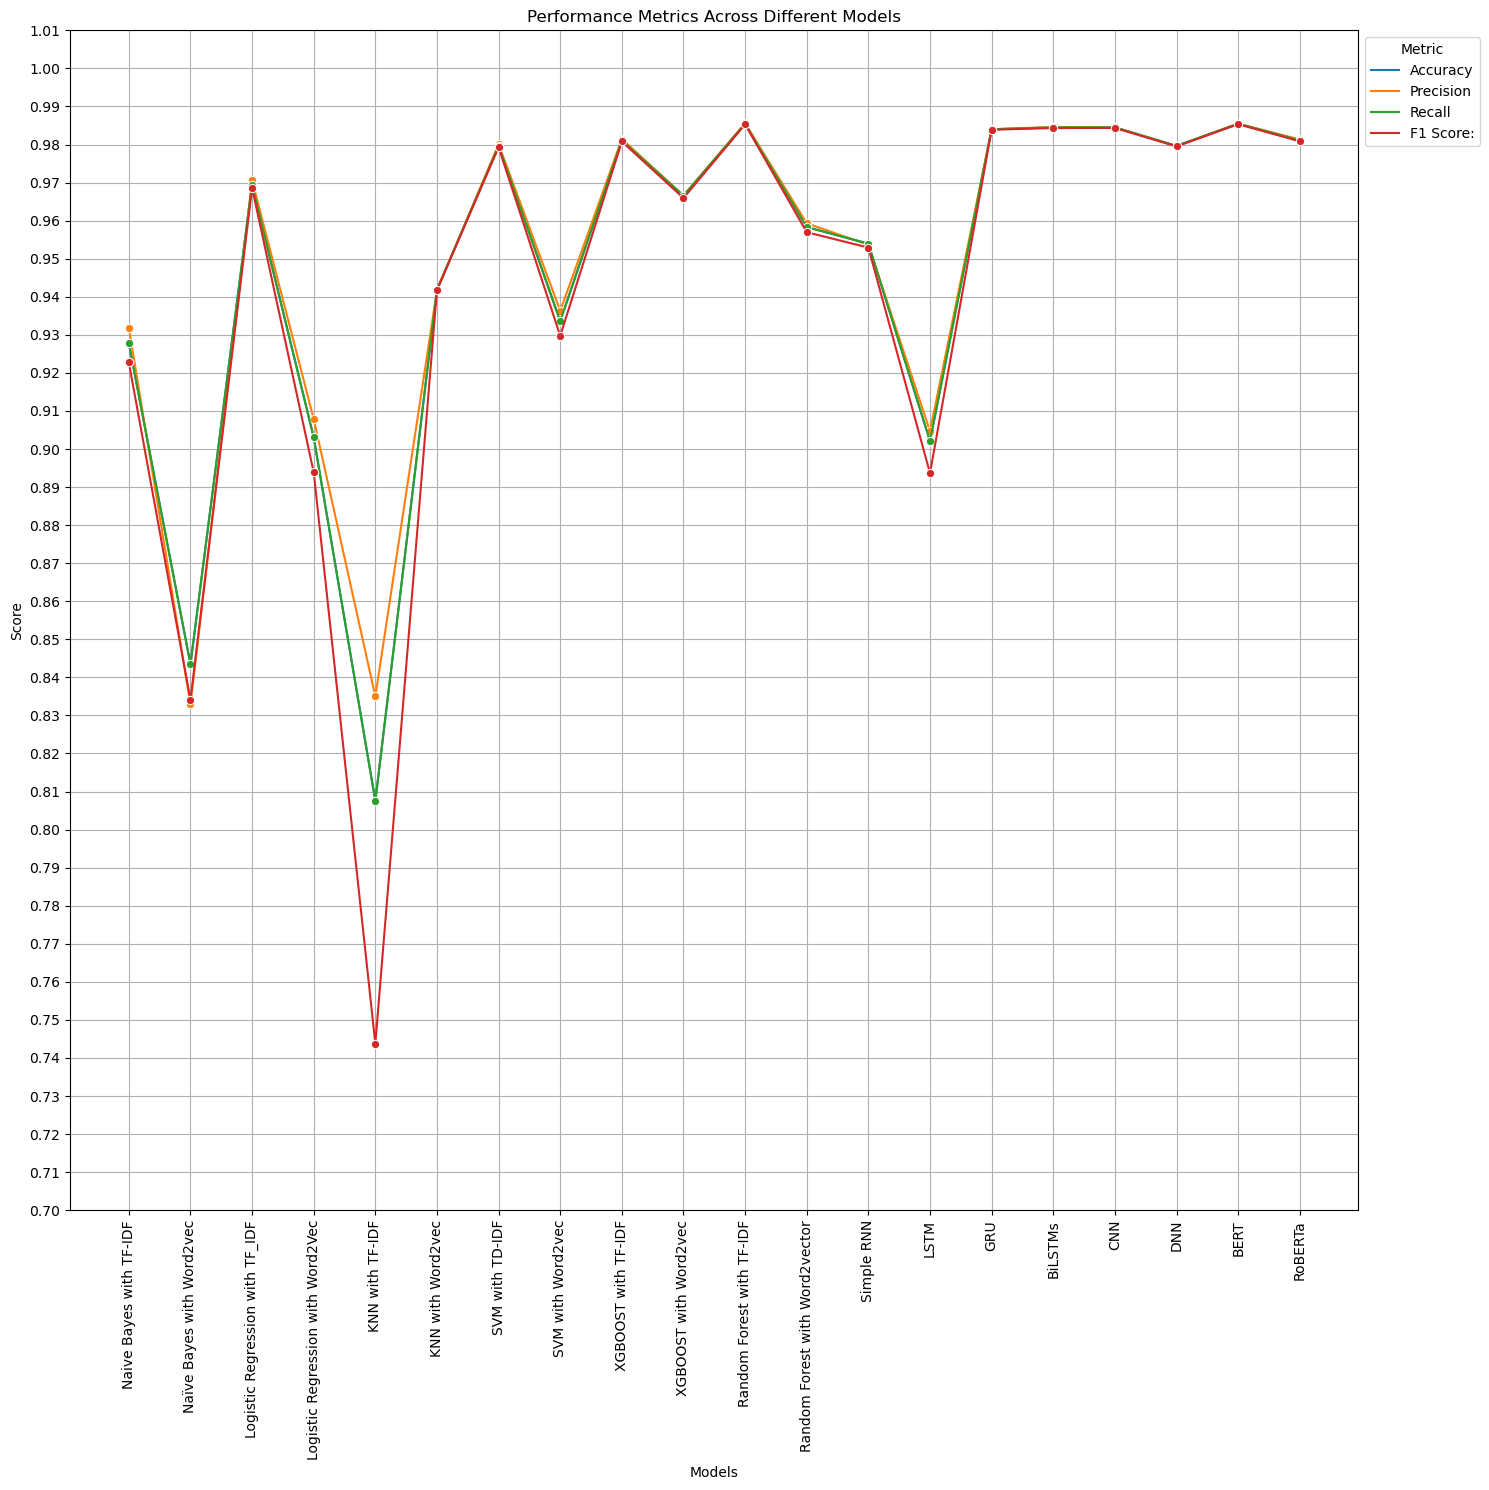

In [175]:
#Line graph camparing all model performance
df = pd.read_csv('data/Model_results.csv')
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(15, 15))
sns.lineplot(data=df_melted, x='Model', y='Score', hue='Metric', marker='o')
plt.xticks(rotation=90)
plt.ylim(0.7, 1.0)
plt.yticks(np.arange(0.7, 1.01, 0.01))
plt.title('Performance Metrics Across Different Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metric', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

Accuracy Bar grap

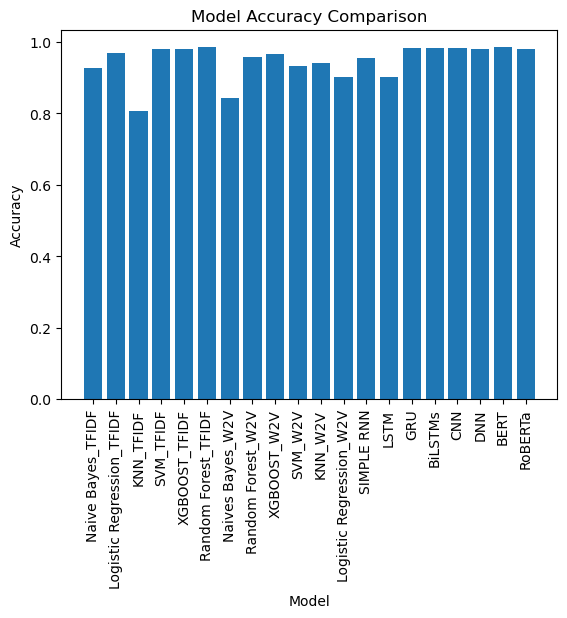

In [166]:
accuracy_scores = {model: accuracy_score(
    y_test, preds) for model, preds in model_predictions.items()}

plt.bar(accuracy_scores.keys(), accuracy_scores.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=90)
plt.show()

Precision and Recall Grouped Bar Chart

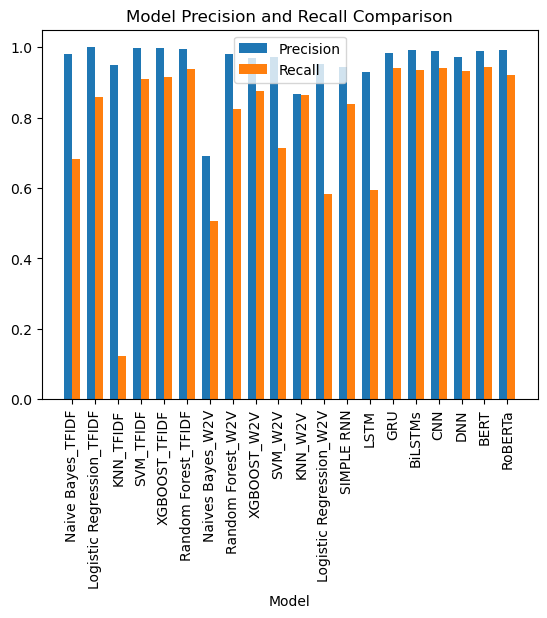

In [167]:
# Calculate precision and recall for each model
precision_scores = {model: precision_score(
    y_test, preds) for model, preds in model_predictions.items()}
recall_scores = {model: recall_score(y_test, preds)
                 for model, preds in model_predictions.items()}


labels = list(model_predictions.keys())
precision_values = list(precision_scores.values())
recall_values = list(recall_scores.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision_values, width, label='Precision')
rects2 = ax.bar(x + width/2, recall_values, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model')
ax.set_title('Model Precision and Recall Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.xticks(rotation=90)
plt.show()

F1 Score chat

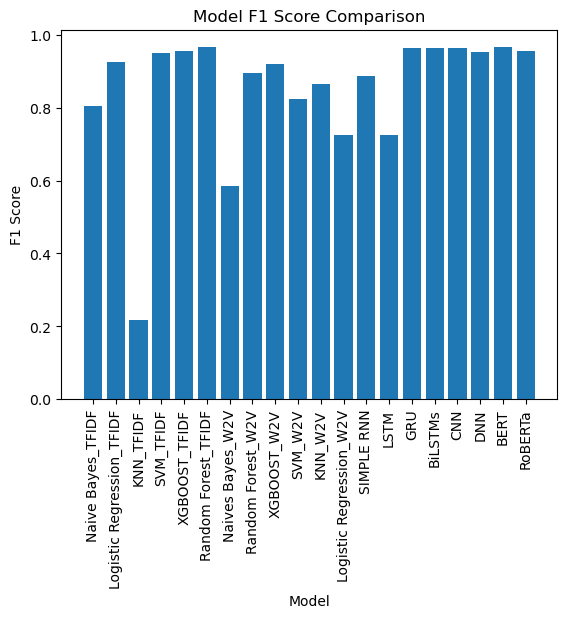

In [168]:
from sklearn.metrics import f1_score

f1_scores = {model: f1_score(y_test, preds)
             for model, preds in model_predictions.items()}

plt.bar(f1_scores.keys(), f1_scores.values())
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.xticks(rotation=90)
plt.show()

ROC curve with AUC

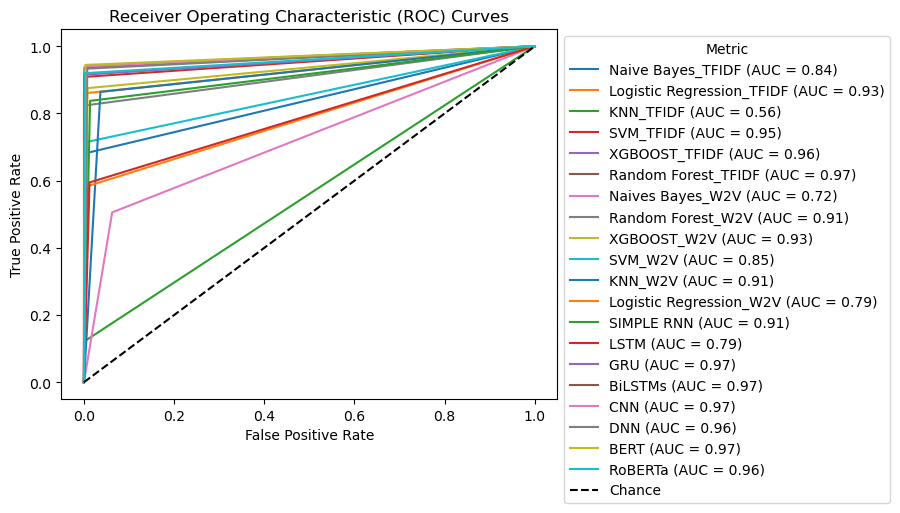

In [176]:
from sklearn.metrics import roc_curve, auc

# Assuming binary classification and the model predictions are probabilities
# for the positive class
fig, ax = plt.subplots()

for model, preds in model_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', label='Chance')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curves')
ax.legend(loc="lower right")
plt.legend(title='Metric', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Precision-Recall Curve

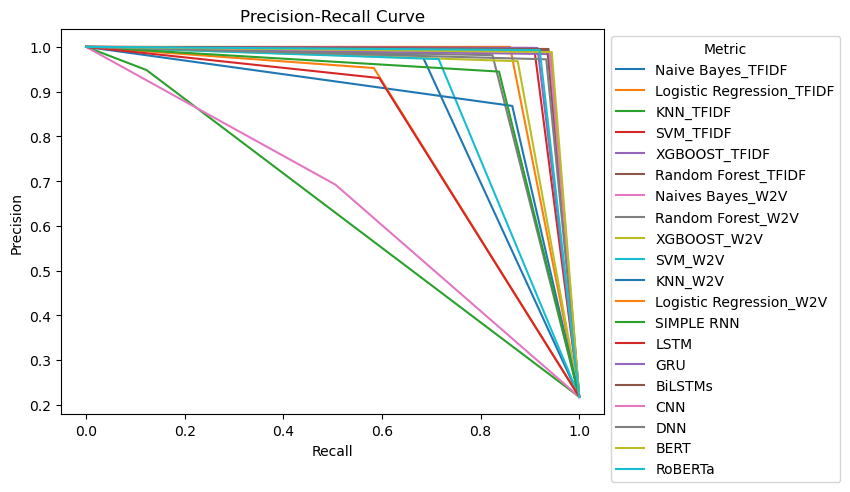

In [177]:
plt.figure(figsize=(7, 5))

for model, preds in model_predictions.items():
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    plt.plot(recall, precision, label=model)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(title='Metric', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()